<a href="https://colab.research.google.com/github/ujin2021/NLP_CAMP/blob/main/day1/01_02_simple_project_%EA%B0%95%EC%9D%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# 단어 긍정(2), 중립(1), 부정(0) 분류 프로젝트

## 데이터

In [ ]:
# 입력 문장 - data
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답 - vocabulary  생성(글자를 숫자로)
labels = [[1, 1, 1, 2],
          [1, 1, 0]]  # 긍정(2), 중립(1), 부정(0)

# 정답 dic
id_to_label = {0: '부정', 1: '중립', 2: '긍정'}

In [ ]:
id_to_label[1]

'중립'

In [ ]:
sentences

['나는 오늘 기분이 좋아', '나는 오늘 우울해']

## Vocabulary

* 띄어쓰기 단위로 분할
* 각 vocab에 고유한 번호 부여

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
  words.extend(sentence.split()) # extend : 한 배열로 합쳐지는 것
words

['나는', '오늘', '기분이', '좋아', '나는', '오늘', '우울해']

In [ ]:
dict.fromkeys(words)

{'기분이': None, '나는': None, '오늘': None, '우울해': None, '좋아': None}

In [ ]:
# 중복 단어 제거
words = list(dict.fromkeys(words))
words # 중복제거된 words

['나는', '오늘', '기분이', '좋아', '우울해']

In [ ]:
# 각 단어별 고유한 번호 부여(글자 to 숫자)
word_to_id = {'[PAD]' : 0, '[UNK]' :  1} # PAD : 길이를 조절할 때, UNK : vocab에 없는 단어
for word in words:
  print(f'{word} : {len(word_to_id)}')
  word_to_id[word] = len(word_to_id) # dict에 들어가는 순서대로 단어에 id를 부여
word_to_id, word_to_id.items()

나는 : 2
오늘 : 3
기분이 : 4
좋아 : 5
우울해 : 6


({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 dict_items([('[PAD]', 0), ('[UNK]', 1), ('나는', 2), ('오늘', 3), ('기분이', 4), ('좋아', 5), ('우울해', 6)]))

In [ ]:
# 각 숫자별 단어 부여 후에 key:value swap
id_to_word = {_id:word for word, _id in word_to_id.items()} # word_to_id.items() : [('[PAD]', 0),...], word : '[PAD]', _id : 0 => _id:word => 0 : '[PAD]'
id_to_word # {id : word}

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'}

## 모델 학습용 데이터 생성

In [ ]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
  train_inputs.append([word_to_id[word] for word in sentence.split()]) # 문장 split -> word_to_id[split한 단어] -> 단어가 id로 => id로 문장 표현
train_inputs

[[2, 3, 4, 5], [2, 3, 6]]

In [ ]:
# 문장의 길이를 모두 동일하게 변경(최대길이 4) - 많은 양의 데이터를 처리하기 쉽도록 길이를 맞춰준다
for row in train_inputs:
  row += [0] * (4 - len(row))
train_inputs

[[2, 3, 4, 5], [2, 3, 6, 0]]

In [ ]:
# train input을 np array로 변환
train_inputs = np.array(train_inputs)
train_inputs

array([[2, 3, 4, 5],
       [2, 3, 6, 0]])

In [ ]:
# train label은 labels를 그대로 사용
train_labels = labels # data에서 label은 출력정답
train_labels

[[1, 1, 1, 2], [1, 1, 0]]

In [ ]:
# 정답길이도 모두 동일하게 변경. 1은 의미가없는(중립)
for row in train_labels:
  row += [1] * (4 - len(row))
train_labels

[[1, 1, 1, 2], [1, 1, 0, 1]]

In [ ]:
# train label을 np array로 변환
train_labels = np.array(train_labels)
train_labels

array([[1, 1, 1, 2],
       [1, 1, 0, 1]])

* word (input)
  1. input sentence를 split 해서 단어(word)단위로 분리
  2. 분리된 word를 vocab으로 변경(중복 단어 제거)
  3. 각 word에 id부여(여기서는 dict에 들어가는 순으로)
  4. 각 word를 id로 대치하여 문장표현하는 list만들기(train_inputs)
  5. 문장이 가지는 word수가 모두 같도록 처리(의미없는 0-padding을 넣어줌)
  6. 단어수가 모두 같아진 id로 표시된 문장을 np array로 변환

* labels
  1. 데이터로 넣어준 label을 가지고 온다
  2. label의 길이를 맞춰준다
  3. np array로 바꾼다

## 모델링

* embedding
  * one-hot encoding과 달리 단어를 밀집 벡터로 만드는 작업을 word embedding이라고 한다
  * 주로 256, 512, 1024 차원을 가진다(현재 코드에선 8차원)
  * 2D 정수 텐서를 입력으로 받고, 3D 텐서를 리턴한다

In [ ]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 8) # vocab의 갯수 : n_vocab, vector의 차원수 : d_model
hidden = embedding(train_inputs)
hidden # 원래의 train_inputs의 shape은 (2, 4). shpae=(2, 4, 8)으로 3D를 리턴해준 것을 알 수 있다. 각 단어당 8개의 원소를 가진다

<tf.Tensor: shape=(2, 4, 8), dtype=float32, numpy=
array([[[-0.03366049,  0.0086485 , -0.0272558 , -0.0386883 ,
          0.02559849, -0.00829139, -0.00878471, -0.01180999],
        [ 0.00829936,  0.02572452, -0.03098699,  0.01510865,
         -0.00394958, -0.00619279, -0.03926581, -0.00731242],
        [ 0.0170739 ,  0.00179764, -0.04283749, -0.0059993 ,
          0.04660744, -0.02145284, -0.03948937,  0.02623561],
        [-0.00872748,  0.02256158, -0.03847399, -0.03653876,
         -0.00487079, -0.02039621, -0.02773414, -0.03488297]],

       [[-0.03366049,  0.0086485 , -0.0272558 , -0.0386883 ,
          0.02559849, -0.00829139, -0.00878471, -0.01180999],
        [ 0.00829936,  0.02572452, -0.03098699,  0.01510865,
         -0.00394958, -0.00619279, -0.03926581, -0.00731242],
        [-0.0339766 ,  0.01340583,  0.04648055, -0.022253  ,
          0.03280025,  0.04745479,  0.00522021, -0.01291474],
        [-0.04085246,  0.03916022, -0.04195162,  0.00167565,
         -0.00962944,  0.

In [ ]:
# 단어의 vector를 이용해서 긍정(2), 부정(0), 중립(1) 확률값 예측(softmax, 확률분포)
linear = tf.keras.layers.Dense(3, activation = tf.nn.softmax) # 3 : 출력이 3가지, 세개 더한게 1이다
outputs = linear(hidden)
outputs # 첫번째 단어 : [0.33402666, 0.33334684, 0.3326265 ] 각 단어 당 3개의 원소를 가진다

<tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
array([[[0.3298789 , 0.33037332, 0.3397478 ],
        [0.33336928, 0.3270026 , 0.33962813],
        [0.3324209 , 0.32581046, 0.34176865],
        [0.3377099 , 0.32399184, 0.3382983 ]],

       [[0.3298789 , 0.33037332, 0.3397478 ],
        [0.33336928, 0.3270026 , 0.33962813],
        [0.3199919 , 0.33536756, 0.34464052],
        [0.3202101 , 0.33931983, 0.34047008]]], dtype=float32)>

In [ ]:
# activation(softmax)를 쓰지 않을 때 한 array를 더했을 때 1이 되지 않음
linear_2 = tf.keras.layers.Dense(3)
logits = linear_2(hidden)
logits

<tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
array([[[ 0.01991158,  0.02340498,  0.04367907],
        [ 0.00246073,  0.01540213,  0.00814183],
        [ 0.01283572,  0.01503796,  0.02119567],
        [-0.00747435,  0.01533613,  0.03505183]],

       [[ 0.01991158,  0.02340498,  0.04367907],
        [ 0.00246073,  0.01540213,  0.00814183],
        [-0.003517  ,  0.0279898 ,  0.00714248],
        [ 0.07118396,  0.06808206,  0.03579073]]], dtype=float32)>

In [ ]:
# softmax를 구현해보자. softmax 계산을 위한 준비 exp(x') / sum(exp(x))
numerator = np.exp(logits) # [0.9975445 , 0.9983827 , 1.0163325 ]
denominator = np.sum(numerator, axis=2, keepdims=True) # [0.9975445 , 0.9983827 , 1.0163325 ] 세 원소를 다 더한값
numerator, denominator

(array([[[0.9584917 , 0.9531151 , 0.9471381 ],
         [0.96198374, 0.93228936, 0.9786167 ],
         [0.9500998 , 0.96462923, 0.9494073 ],
         [0.9549486 , 0.9229382 , 0.9542817 ]],
 
        [[0.9584917 , 0.9531151 , 0.9471381 ],
         [0.96198374, 0.93228936, 0.9786167 ],
         [1.02802   , 1.0193917 , 0.98935324],
         [0.9824005 , 0.9446772 , 0.9702152 ]]], dtype=float32),
 array([[[2.8587449],
         [2.8728898],
         [2.8641365],
         [2.8321686]],
 
        [[2.8587449],
         [2.8728898],
         [3.0367649],
         [2.8972929]]], dtype=float32))

In [ ]:
# 두 결과값 비교
probs = numerator/ denominator # 확률 분포 값
probs # 위에서 softmax 사용한 것과 같다(softmax 식 참고)

array([[[0.33528408, 0.33340335, 0.33131257],
        [0.33484882, 0.32451275, 0.34063846],
        [0.33172297, 0.33679584, 0.33148116],
        [0.3371793 , 0.32587686, 0.3369438 ]],

       [[0.33528408, 0.33340335, 0.33131257],
        [0.33484882, 0.32451275, 0.34063846],
        [0.33852473, 0.33568344, 0.32579184],
        [0.3390753 , 0.3260551 , 0.33486956]]], dtype=float32)

In [ ]:
# 위의 logit을 구현해보자. dense의 weight, bias
weight, bias = linear_2.get_weights()
weight, bias

(array([[ 0.5102344 ,  0.63268405,  0.21943581],
        [-0.28224522, -0.5281517 ,  0.11931717],
        [ 0.5824066 ,  0.66847056,  0.7010898 ],
        [-0.05694318, -0.3630721 ,  0.345563  ],
        [-0.13464016, -0.03539056, -0.48931855],
        [ 0.44512373,  0.3112226 , -0.26574194],
        [ 0.39553314,  0.7335636 ,  0.3071025 ],
        [-0.12736511,  0.6817823 ,  0.20810694]], dtype=float32),
 array([0., 0., 0.], dtype=float32))

In [ ]:
# numpy를 이용한 xW+b(행벡터), (Wx)T = xTWT (T : transpose)
logits = np.matmul(hidden, weight) + bias # matmul : 행렬곱
logits

array([[[-0.0423944 , -0.04801963, -0.0543104 ],
        [-0.03875773, -0.070112  , -0.02161522],
        [-0.05118816, -0.03601152, -0.05191739],
        [-0.04609776, -0.08019292, -0.04679641]],

       [[-0.0423944 , -0.04801963, -0.0543104 ],
        [-0.03875773, -0.070112  , -0.02161522],
        [ 0.02763464,  0.01920606, -0.01070392],
        [-0.01775627, -0.05691208, -0.03023733]]], dtype=float32)

In [ ]:
#@title 위에서 구현한 Model을 function으로 나타내기
def build_model(n_vocab, d_model, n_seq, n_out):
  """
  동작만 하는 간단한 모델
  :param n_vocab : vocabulary 단어 수
  :param d_model: 단어를 의미하는 벡터의 차원 수
  :param n_seq : 문장 길이(단어 수)
  :param n_out: 예측할 class 개수
  """
  inputs = tf.keras.layers.Input((n_seq,)) # (bs, n_seq), bs : batch size, n_seq : 입력갯수(4)
  
  # 입력단어를 vector로 변환
  embedding = tf.keras.layers.Embedding(n_vocab, d_model)
  hidden = embedding(inputs)  # (bs, n_seq, d_model)
  # 단어의 vector를 이용해 정답 확률값 예측
  linear = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)
  outputs = linear(hidden) # (bs, n_seq, n_out)

  # 학습할 모델 선언
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

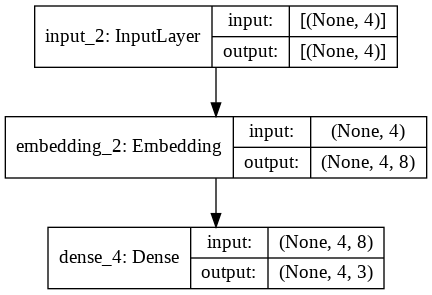

In [ ]:
# 모델 생성
model = build_model(len(word_to_id), 8, 4, 3)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 4, 8)              56        
_________________________________________________________________
dense_4 (Dense)              (None, 4, 3)              27        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


## 학습

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_inputs, train_labels, epochs=100, batch_size=16)

Epoch 1/100
1/1 [==============================] - 1s 724ms/step - loss: 1.1078 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1051 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1025 - accuracy: 0.2500
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 1.0998 - accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 0s 9ms/step - loss: 1.0972 - accuracy: 0.6250
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 1.0946 - accuracy: 0.6250
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0919 - accuracy: 0.6250
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0893 - accuracy: 0.6250
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 1.0867 - accuracy: 0.6250
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 1.0841 - accuracy: 0.6250
Epoch 11/100
1/1 [=

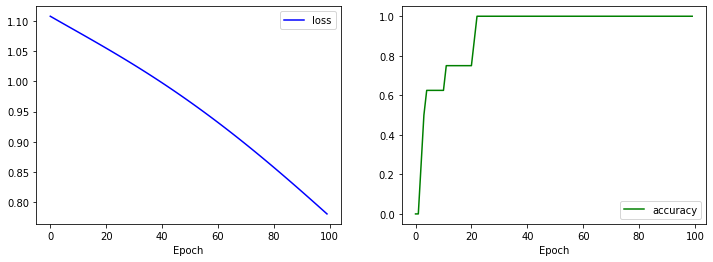

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 평가

In [ ]:
# 모델 평가(원래는 train data로 test하면 안되고 test data를 사용해야함)
model.evaluate(train_inputs, train_labels)

1/1 [==============================] - 0s 179ms/step - loss: 0.7765 - accuracy: 1.0000


[0.7765437364578247, 1.0]

## 예측

In [ ]:
# 추론할 입력
string = '나는 기분이 우울해'

In [ ]:
# 입력을 숫자로 변경
infer_input = [word_to_id[word] for word in string.split()]
infer_input

[2, 4, 6]

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (모델자체를 길이가 4인것으로 학습시켰음)
infer_input += [0] * (4 - len(infer_input))
infer_input

[2, 4, 6, 0]

In [ ]:
# numpy array 변환 (batch size 1 추가)
infer_inputs = np.array([infer_input])
infer_input

[2, 4, 6, 0]

In [ ]:
# 긍정/부정 추론
y_preds = model.predict(infer_inputs)
y_preds

array([[[0.25532877, 0.4890173 , 0.25565392],
        [0.2494012 , 0.4705688 , 0.28002998],
        [0.3857692 , 0.30711716, 0.30711365],
        [0.25757247, 0.47194436, 0.2704832 ]]], dtype=float32)

In [ ]:
# 확률의 max값을 추론 값으로 결정
y_pred_class = np.argmax(y_preds, axis=2)
y_pred_class 
# [1, 1, 0, 1] : 중립 중립 부정(우울해) 중립(padding)

array([[1, 1, 0, 1]])

## 참고(문법)

### dict.fromkeys

In [ ]:
# python dict fromkeys
# dict.fromkeys(list)
keys = ['a', 'b', 'c', 'd']
x = dict.fromkeys(keys) # list를 key값으로하고, value는 None인 dict 생성
x, list(x) # list로 하면 key값만 리스트로 반환

In [ ]:
y = dict.fromkeys(keys, 100) # value의 default값도 설정가능
y, list(y)

In [ ]:
keys_2 = ['a', 'b', 'c', 'd', 'a', 'a', 'b'] # 중복 원소가 있는 리스트
z = dict.fromkeys(keys) # 중복된 것은 제거됨
z 

In [ ]:
list({'a': 100, 'b': 100, 'c': 100, 'd': 100}) # key값만 반환